In [9]:
import os
import json
from time import clock
from PIL import Image
from skimage.measure import block_reduce
from scipy.misc import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Loading Tiny ImageNet

In [197]:
data = {}
t1 = clock()
for folder in os.listdir("tiny-imagenet-200/train"):
    for subfolder in os.listdir("tiny-imagenet-200/train/"+folder):
        if subfolder == "images":
            for file in os.listdir("tiny-imagenet-200/train/"+folder+"/"+subfolder):
                img = Image.open("tiny-imagenet-200/train/"+folder+"/"+subfolder+"/"+file, "r")
                if file[:9] in data.keys():
                    data[file[:9]].append(np.array(img))
                else:
                    data[file[:9]] = [np.array(img)]
t2 = clock()
print("Total time elapsed:", t2-t1)

KeyboardInterrupt: 

A sample pixel array for image class n02795169:
(64, 64, 3)


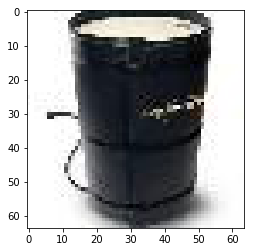

In [13]:
# let's preview a single item in the data dictionary
for im, arrs in data.items():
    print("A sample pixel array for image class", im+":") 
    print(arrs[0])
    plt.imshow(arrs[0])
    break
plt.show()

## Building Alexnet

### Helper Functions:

In [60]:
def conv(x, filter_height, filter_width, num_filters, stride_height, stride_width, name, padding="SAME", groups=1):
    channels = int(x.shape[-1])
    
    # create lambda function for convolution
    convolve = lambda a, b: tf.nn.conv2d(a, b, strides=[1, stride_height, stride_width, 1], padding=padding)
    
    with tf.variable_scope(name) as scope:
        w = tf.get_variable("w", shape=[filter_height, filter_width, int(channels/groups), num_filters])
        b = tf.get_variable("b", shape=[num_filters])
        
        conv = convolve(x, w)    
        output = tf.reshape(tf.nn.bias_add(conv, b), conv.shape.as_list())
        relu = tf.nn.relu(output, name=scope.name)
        
        return relu  

In [189]:
def fully_connected(x, dim_in, dim_out, name):
    with tf.variable_scope(name) as scope:
        w = tf.get_variable("w", shape=[dim_in, 1], trainable=True)
        b = tf.get_variable("b", [dim_out], trainable=True)
        
        output = tf.tensordot(x, w, axes=1) + b
        relu = tf.nn.relu(output) 
        
        return relu

In [62]:
def max_pool(x, filter_height, filter_width, stride_height, stride_width, name, padding='SAME'):
  return tf.nn.max_pool(x, ksize=[1, filter_height, filter_width, 1], 
                        strides = [1, stride_height, stride_width, 1], padding=padding, name=name)

In [63]:
def lrn(x, name, radius=5, alpha=0.0001, beta=0.75, bias=2.0):
  return tf.nn.local_response_normalization(x, depth_radius=radius, alpha=alpha, beta=beta, bias=bias, name=name)

In [64]:
def dropout(x, keep_prob):
  return tf.nn.dropout(x, keep_prob)

### Graph:

Let:  
$n$ = the number of filters,    
$f$ = the filter size,   
$s$ = the stride

**Input Layer**: image of dimension `64x64x3`.

**First Convolutional Layer**: 


In [65]:
# parameters
batch_size = 1
n_dim = [batch_size, 64, 64, 3]
n_classes = 1000

In [196]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=n_dim)  
Y = tf.placeholder(tf.float32,[None,n_classes])

# first layer: conv -> pool -> lrn
print("X.shape:", X.shape)

print("\n")

c1 = conv(X, filter_height=11, filter_width=11, num_filters=96, stride_height=3, stride_width=3, name="c1")
print("c1.shape:", c1.shape)
pool1 = max_pool(c1, filter_height=3, filter_width=3, stride_height=2, stride_width=2, name="pool1")
print("pool1.shape:", pool1.shape)
lrn1 = lrn(pool1, name="lrn1")

print("\n")

# second layer: conv -> pool -> lrn
c2 = conv(lrn1, filter_height=5, filter_width=5, num_filters=256, stride_height=1, stride_width=1, name="c2")
print("c2.shape:", c2.shape)
pool2 = max_pool(c2, filter_height=3, filter_width=3, stride_height=2, stride_width=2, name="pool2")
print("pool2.shape", pool2.shape)
lrn2 = lrn(pool2, name="lrn2")

print("\n")

# third layer: conv
c3 = conv(lrn2, filter_height=3, filter_width=3, num_filters=384, stride_height=1, stride_width=1, name="c3")
print("c3.shape", c3.shape)

print("\n")

# fourth layer: conv
c4 = conv(c3, filter_height=3, filter_width=3, num_filters=384, stride_height=1, stride_width=1, name="c4")
print("c4.shape", c4.shape)

print("\n")

# fifth layer: conv -> pool
c5 = conv(c4, filter_height=3, filter_width=3, num_filters=384, stride_height=1, stride_width=1, name="c5")
print("c5.shape", c5.shape)
pool5 = max_pool(c5, filter_height=3, filter_width=3, stride_height=2, stride_width=2, name="pool5")
print("pool5.shape", pool5.shape)

# reshape fifth conv layer to fit fully-connected layer
# shape = np.prod([i for i in pool5.shape])
shape = np.prod(pool5.get_shape().as_list())
flattened = tf.reshape(pool5, [shape, 1])
print("flattened.shape:", flattened.shape)

print("\n")

# sixth layer: fully-connected
fc6 = fully_connected(flattened, dim_in=flattened.shape[0], dim_out=flattened.shape[0], name="fc6")
fc6.set_shape([shape, 1])
print("fc6.shape:", fc6.get_shape())

print("\n")

# seventh layer: fully connected
fc7 = fully_connected(fc6, dim_in=fc6.shape[1], dim_out=fc6.shape[1], name="fc7")
fc7.set_shape([shape, 1])
print("fc7.shape:", fc7.shape)


model = tf.global_variables_initializer()

X.shape: (1, 64, 64, 3)


c1.shape: (1, 22, 22, 96)
pool1.shape: (1, 11, 11, 96)


c2.shape: (1, 11, 11, 256)
pool2.shape (1, 6, 6, 256)


c3.shape (1, 6, 6, 384)


c4.shape (1, 6, 6, 384)


c5.shape (1, 6, 6, 384)
pool5.shape (1, 3, 3, 384)
flattened.shape: (3456, 1)


fc6.shape: (3456, 1)


fc7.shape: (3456, 1)


## Preprocessing CAPTCHA images

As with the ImageNet data, we need virtually no preprocessing, save for downsampling the images (currently `100x100`) to fit the dimensions of our input layer (`64x64`).

In [19]:
# iterate through recaptcha dataset
for folder in os.listdir("recapt_offline"):
    if folder != ".DS_Store":
        for file in os.listdir("recapt_offline/"+folder):
            if file == "info.txt":
                json_string = open("recapt_offline/"+folder+"/"+file, "r")
                json_dict = json.load(json_string)  # convert json to dict
                
                correct = json_dict["correct_answer"]  # array of numbers containing indices (1-9) of correct images
                target = json_dict["desc"]["keyword"]  # string representing target image (e.g. "cake")
                
            if "cand" in file:
                img = Image.open("recapt_offline/"+folder+"/"+file, "r")
                downsampled = block_reduce(np.array(img), block_size=(2, 2, 1), func=np.mean)
                # print(downsampled)
                new = Image.fromarray(downsampled, 'RGB')
                # plt.figure()
                # plt.imshow(downsampled, interpolation="None")
                # plt.show()